## 안전 운전자 예측

- https://www.kaggle.com/code/werooring/ch8-eda
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- https://www.kaggle.com/code/bertcarremans/data-preparation-exploration/notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

### 데이터 둘러보기

In [2]:
data_path = 'data/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [3]:
print(train.shape)
print(test.shape)

(595212, 58)
(892816, 57)


In [4]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


- 데이터가 크고 피처수가 많음

In [5]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


- 타깃 값 확률이 일괄 입력되어 있다.

우리는 운전자가 보험금을 청구할 확률을 예측해야 한다.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

- 데이터 타입은 int64, float64 중에 하나이다.

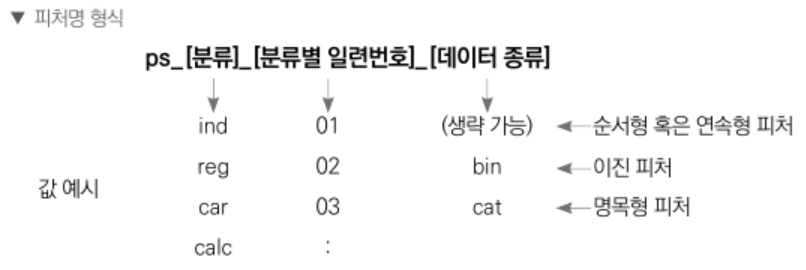

결측치 확인

In [7]:
train['ps_car_03_cat'].value_counts()

-1    411231
 1    110709
 0     73272
Name: ps_car_03_cat, dtype: int64

- 결측치가 -1로 되어 있다.

In [8]:
import missingno as msno

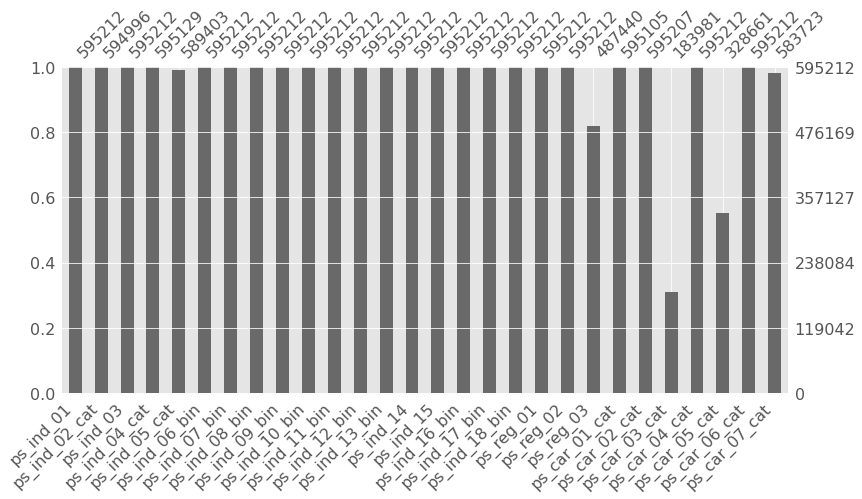

In [9]:
# 훈련 데이터 복사본에서 -1을 np.NaN로 변환
train_copy = train.copy().replace(-1, np.NaN)

# 결측값 시각화(처음 28개만)
msno.bar(df=train_copy.iloc[:, 1:29], figsize=(13, 6));

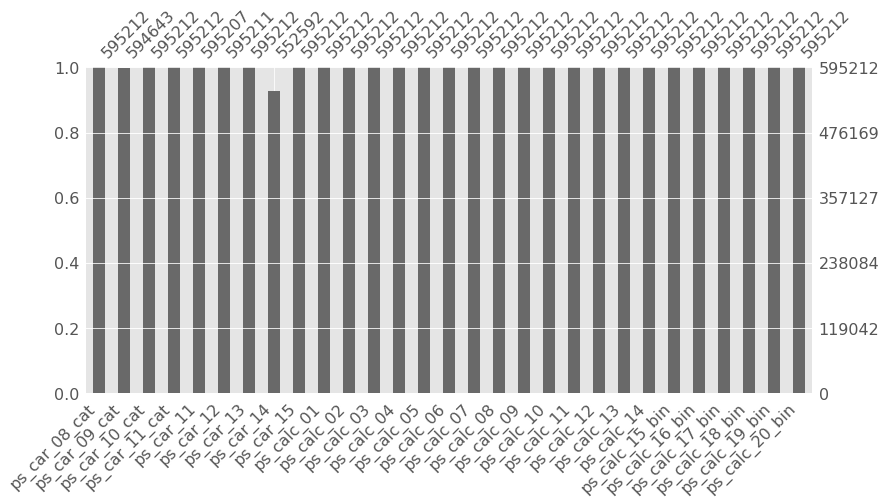

In [10]:
msno.bar(df=train_copy.iloc[:, 29:], figsize=(13, 6));

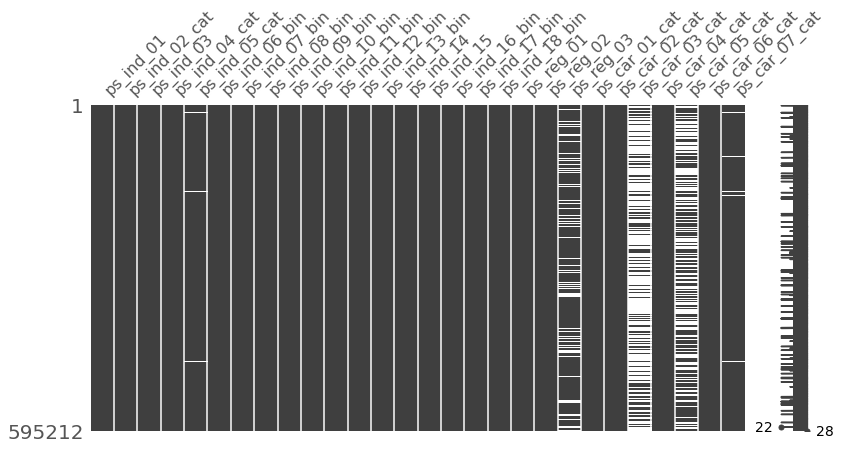

In [11]:
msno.matrix(df=train_copy.iloc[:, 1:29], figsize=(13, 6));

피처 요약표

In [12]:
def resumetable(df):
    print(f'데이터 세트 형상 : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df == -1).sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [13]:
summary = resumetable(train)
summary

데이터 세트 형상 : (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,None
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,None
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [14]:
summary[summary['데이터 종류']=='명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [15]:
summary[summary['데이터 타입']=='float64'].index

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')

#### 데이터 시각화

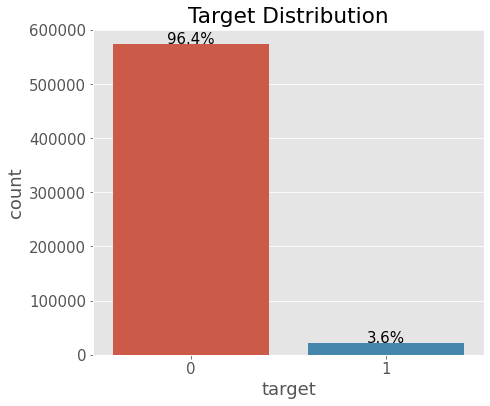

In [16]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(left_coord + width/2.0,     # x축 위치
                height + total_size*0.001,  # y축 위치
                '{:1.1f}%'.format(percent), # 입력 텍스트
                ha='center')                # 가운데 정렬
    
mpl.rc('font', size=15)
plt.figure(figsize=(7, 6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution');

- 3.6프로만 보험청구. 사고가 흔하지 않다.

In [17]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, 
                                  size=(12, 18)):
    mpl.rc('font', size=9) 
    plt.figure(figsize=size)                     # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        # ax축에 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
        sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)

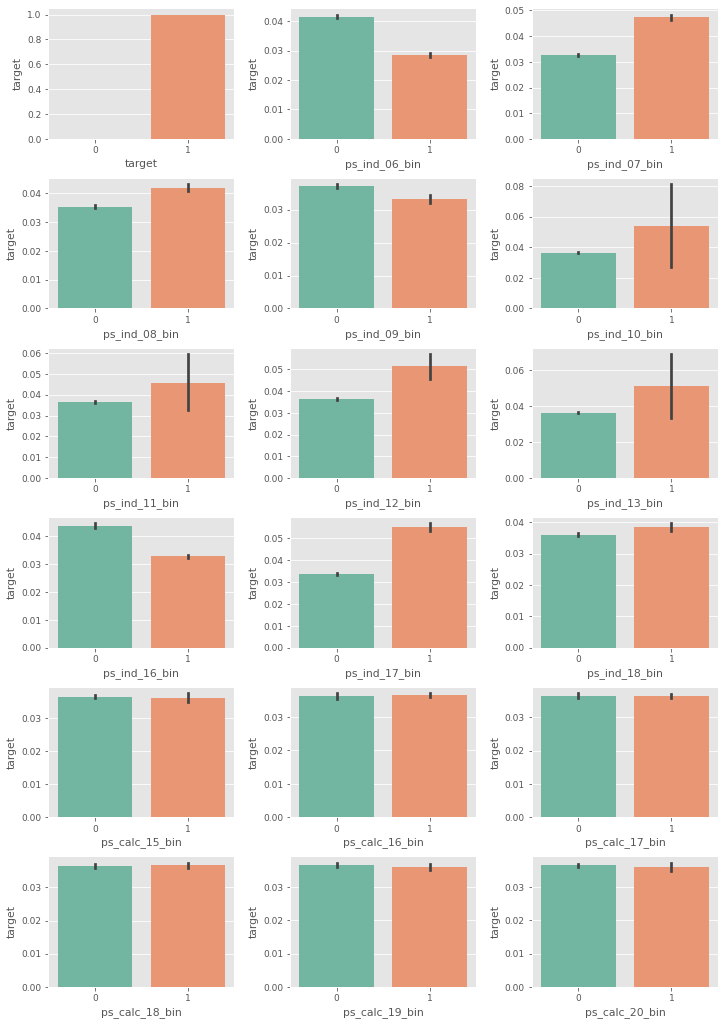

In [18]:
bin_features = summary[summary['데이터 종류'] == '이진형'].index # 이진 피처
# 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
plot_target_ratio_by_features(train, bin_features, 6, 3) # 6행 3열 배치

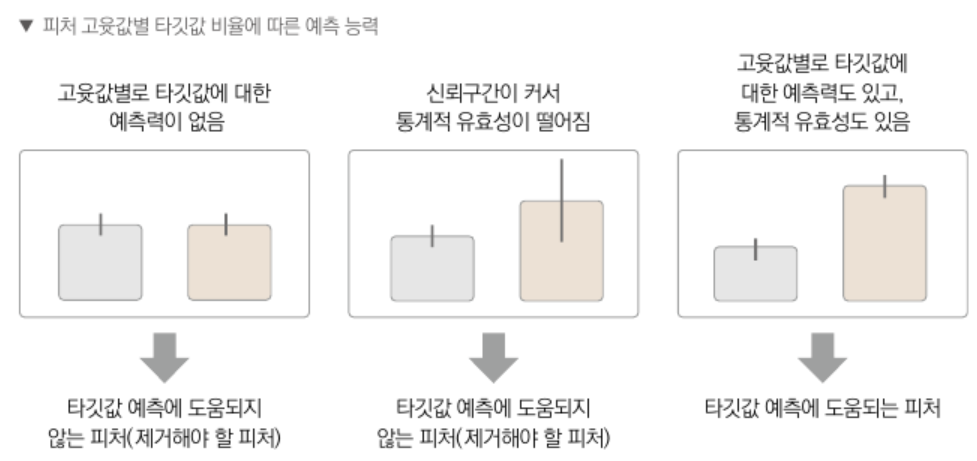

- 10_bin ~ 13_bin : 신뢰구간이 넓어 통계적 유효성이 떨어짐  
- 15_bin ~ 20_bin : 고윳값 별 타깃값 비율 차이가 없어 타깃 값 예측력이 없음

연속형 피처

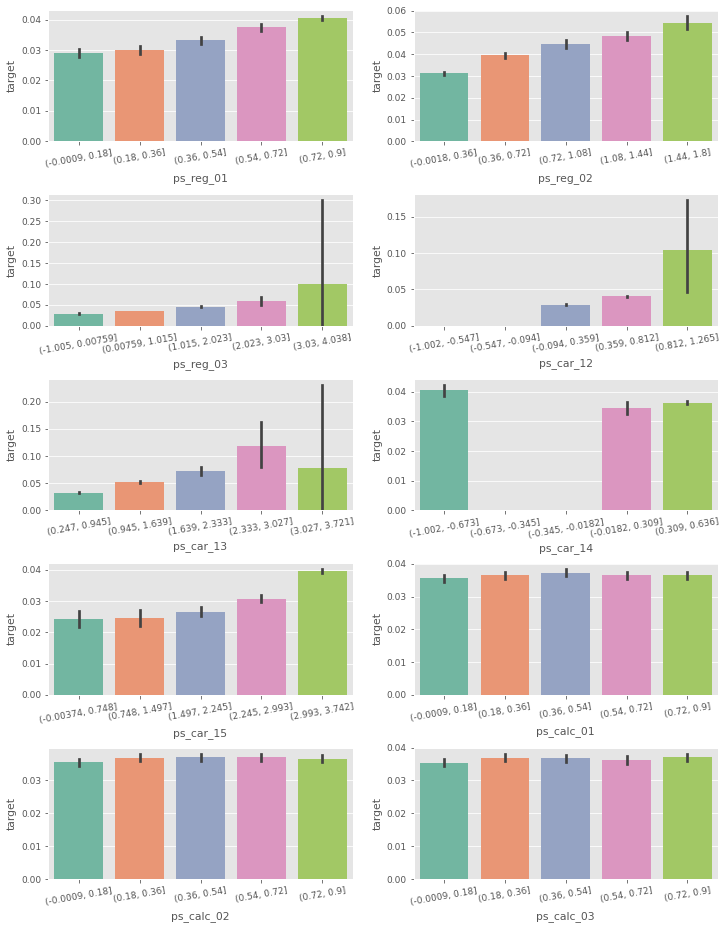

In [19]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index # 연속형 피처

plt.figure(figsize=(12, 16))                # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)              # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.4) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    train[cont_feature] = pd.cut(train[cont_feature], 5)

    ax = plt.subplot(grid[idx])                # 분포도를 그릴 서브플롯 설정
    sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전

명목형 피처

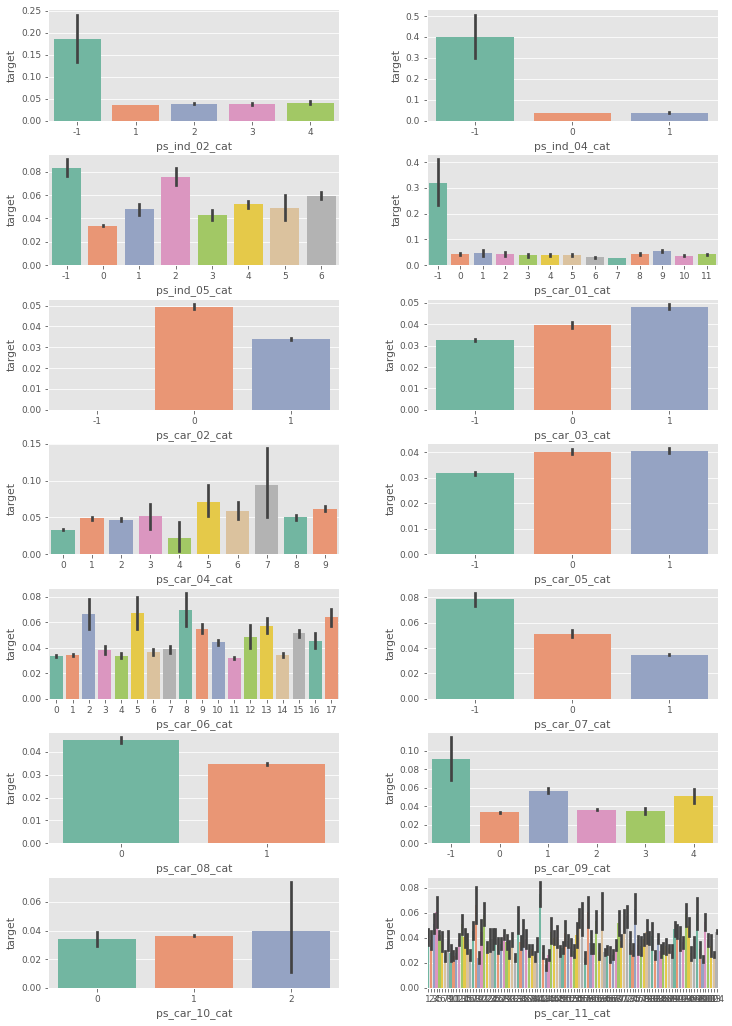

In [20]:
nom_features = summary[summary['데이터 종류']=='명목형'].index

plot_target_ratio_by_features(train, nom_features, 7, 2) # 7행 2열

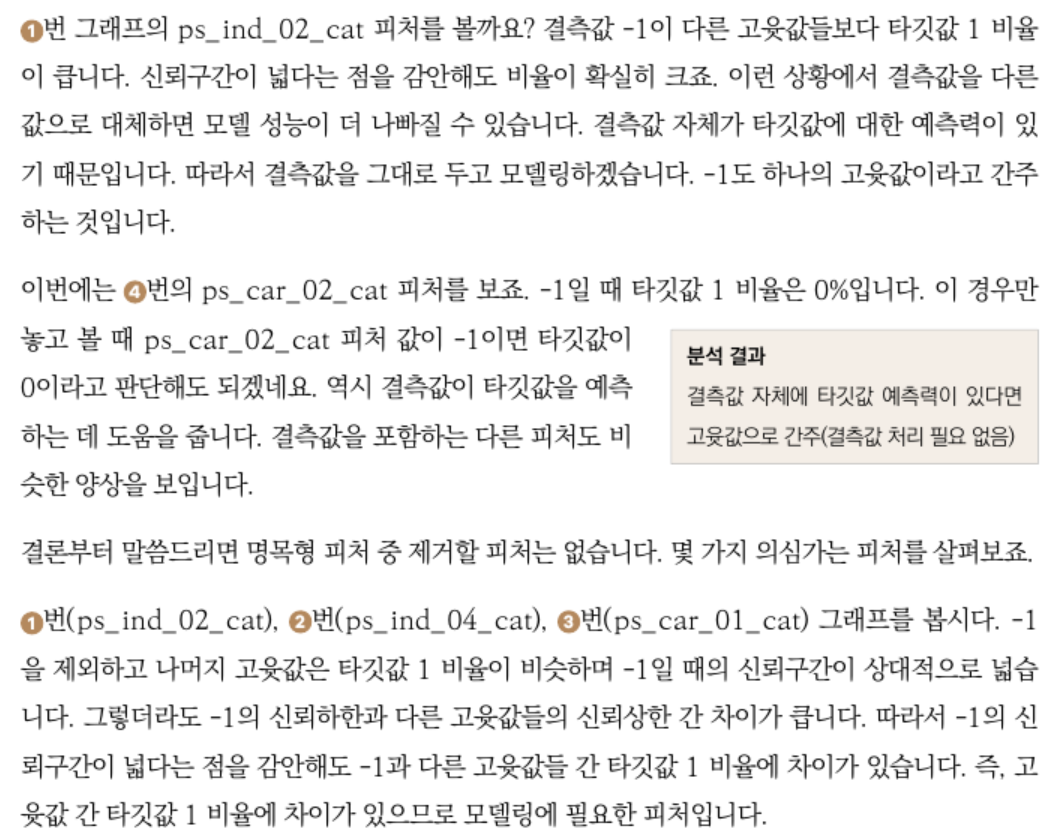

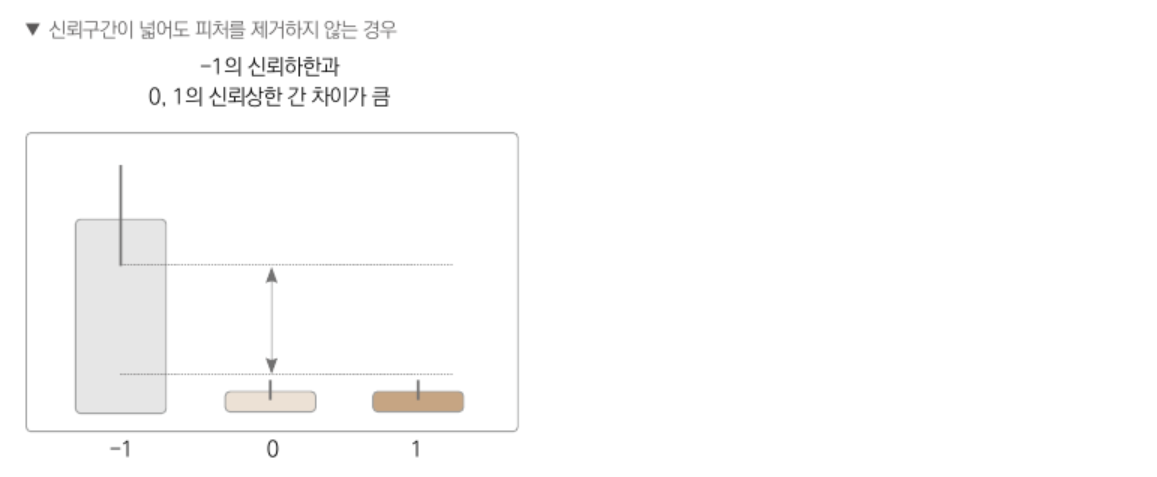

순서형 피처

In [21]:
ord_features = summary[summary['데이터 종류'] == '순서형'].index # 순서형 피처

plot_target_ratio_by_features(train, ord_features, 8, 2, (12, 20)) # 8행 2열

<Figure size 864x1440 with 0 Axes>

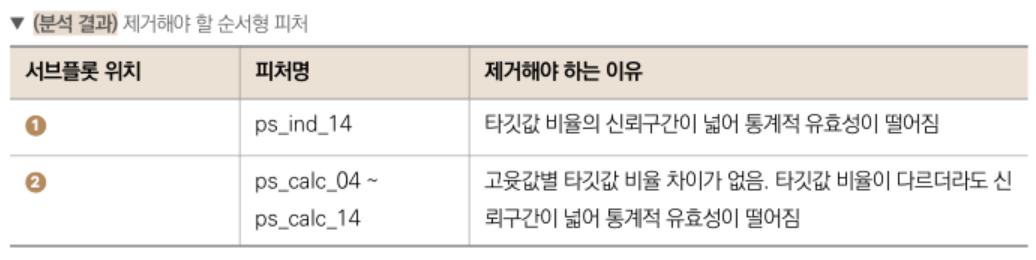

연속형 피처

연속평 피처는 고윳값이 매우 많다. 따라서 값을 몇개의 구간으로 나누어서 구간 별 타깃값의 비율을 알아본다.  


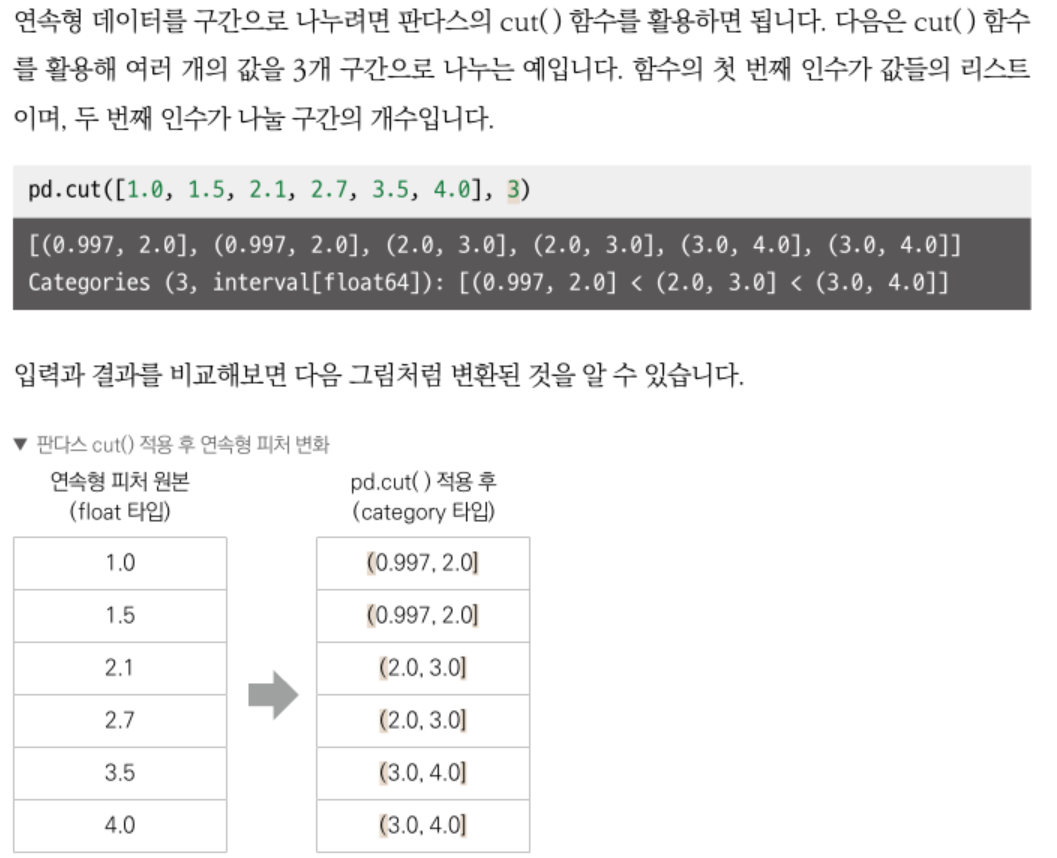

In [23]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index # 연속형 피처

plt.figure(figsize=(12, 16))                # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)              # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.4) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    train[cont_feature] = pd.cut(train[cont_feature], 5)

    ax = plt.subplot(grid[idx])                # 분포도를 그릴 서브플롯 설정
    sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 864x1152 with 0 Axes>

히트맵 그리기

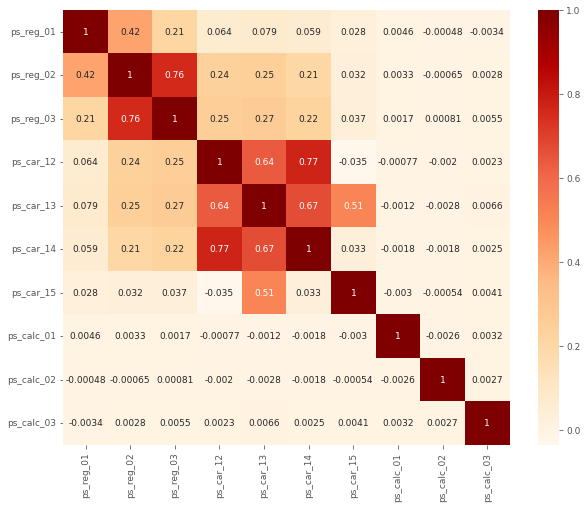

In [24]:
train_copy = train_copy.dropna() # np.NaN 값 삭제

plt.figure(figsize=(10, 8))
cont_corr = train_copy[cont_features].corr()     # 연속형 피처 간 상관관계 
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # 히트맵 그리기

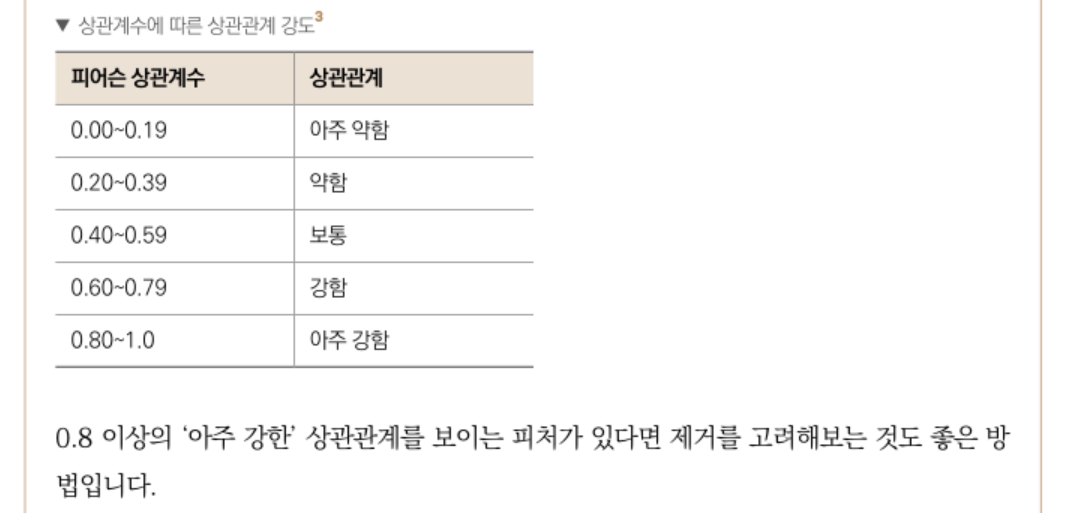

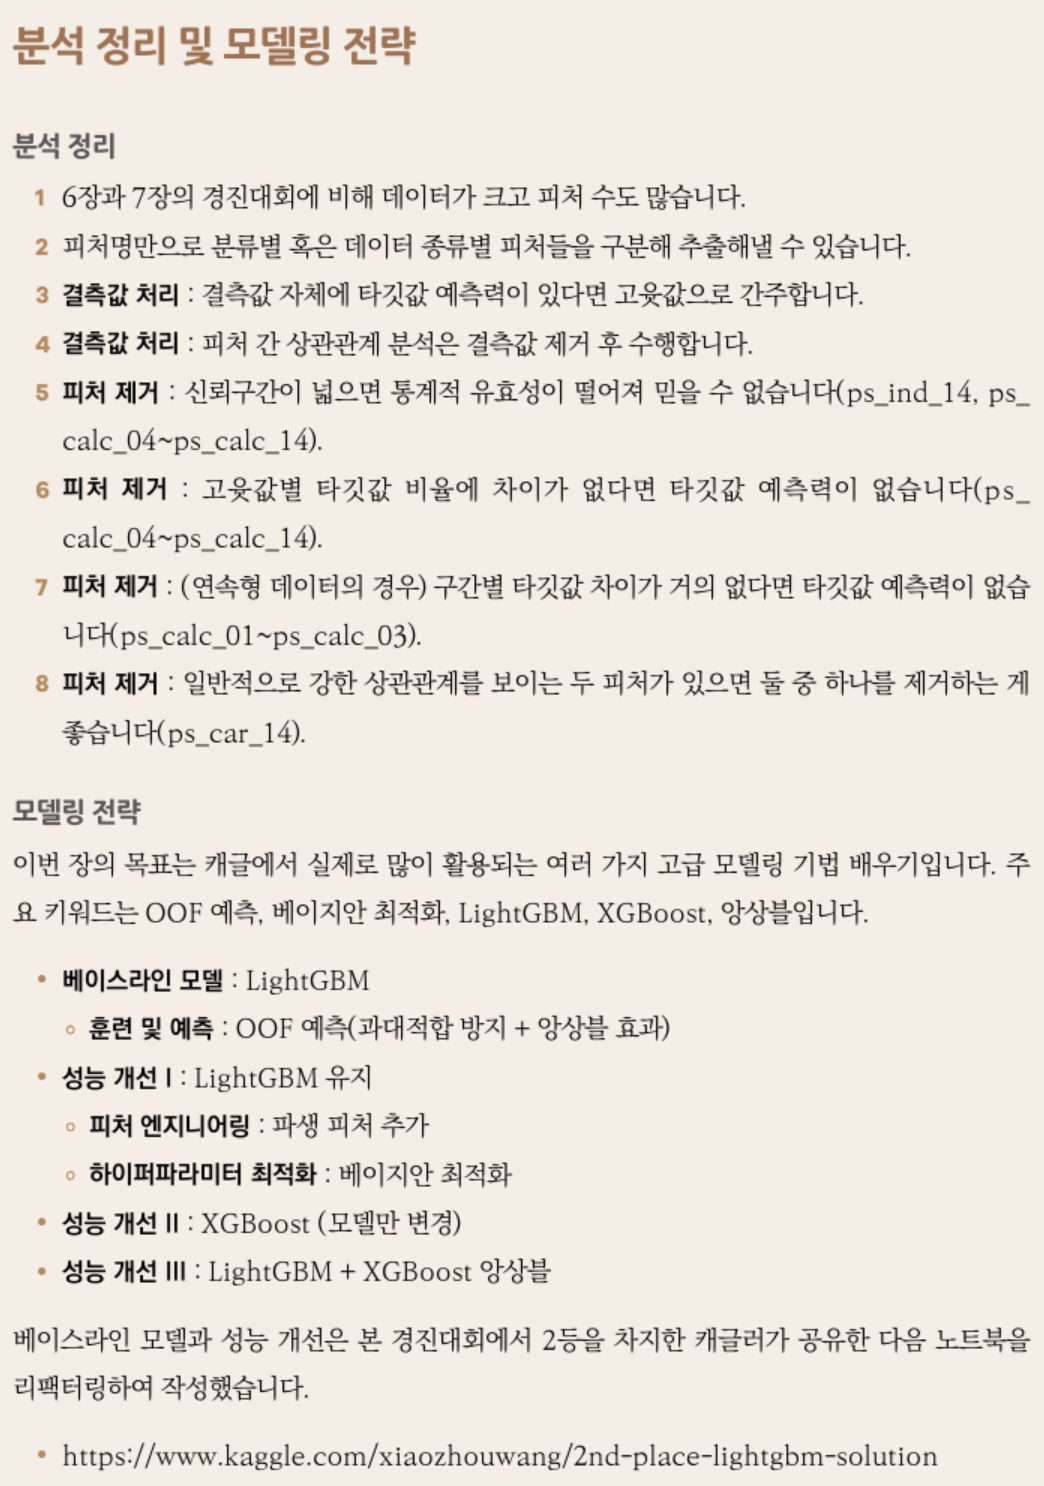

### 베이스라인 모델

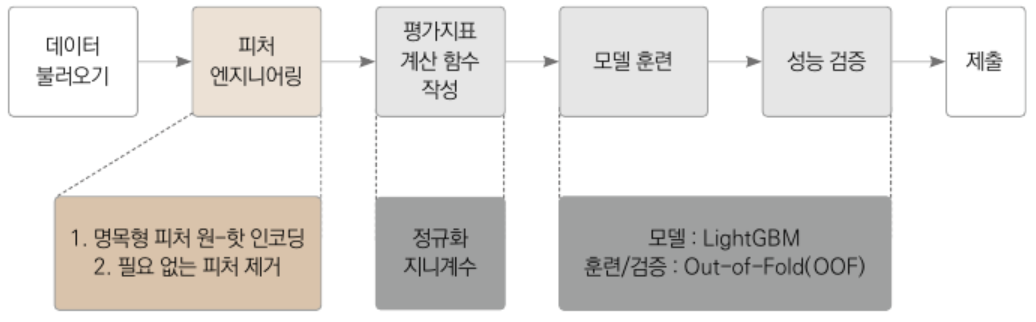

In [25]:
data_path = 'data/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')

submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

#### 피처 엔지니어링

데이터 합치기

In [26]:
all_data = pd.concat([train, test], ignore_index=True)

In [27]:
all_data = all_data.drop('target', axis = 1)

In [28]:
all_features = all_data.columns

In [29]:
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

명목형 피처 원핫 인코딩

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

필요 없는 피처 제거

In [32]:
# 추가로 제거할 피처
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# '1) 명목형 피처, 2) calc 분류의 피처, 3) 추가 제거할 피처'를 제외한 피처
remaining_features = [feature for feature in all_features 
                      if ('cat' not in feature and 
                          'calc' not in feature and 
                          feature not in drop_features)]

데이터 합치기

In [33]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')

데이터 나누기

In [34]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

#### 평가지표 계산 함수 작성

본 경진대회의 평가지표는 정규화된 지니계수이다. 기본으로 제공되지 않아서 직접 만들어야 한다.

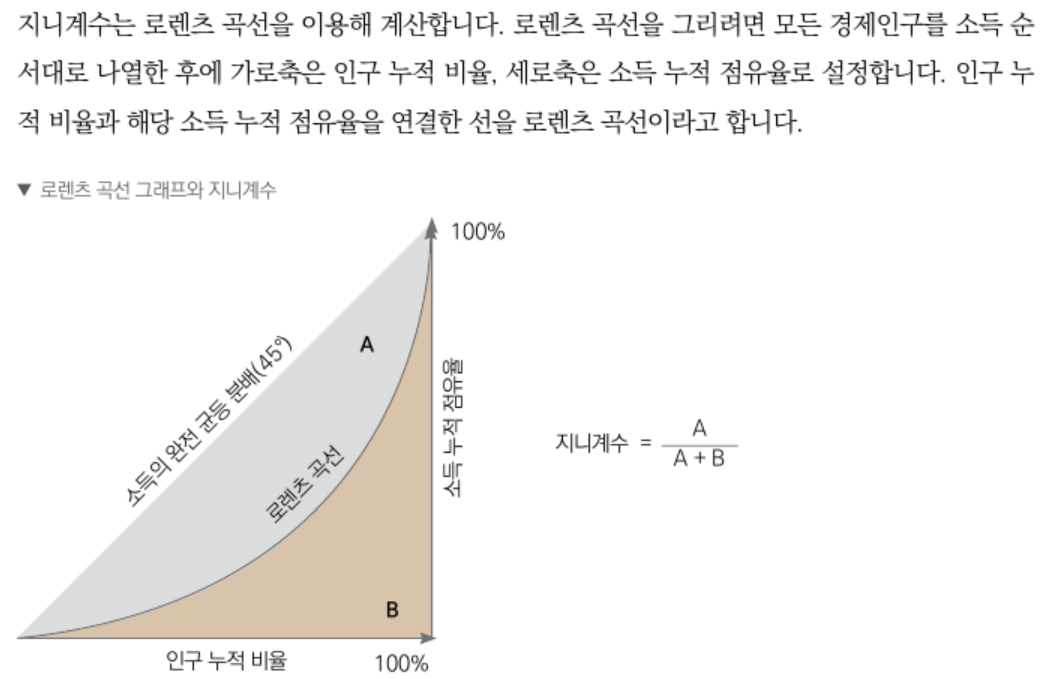

지니계수란 불평등 정도를 나타내는 지표.  
클수록 불평등.  

머신러닝에서 지니계수는 모델의 예측성능을 측정하는 데 쓰인다.   
머신러닝에서는 예측 값을 크기순으로 정렬해서 로렌츠 곡선을 구한다.

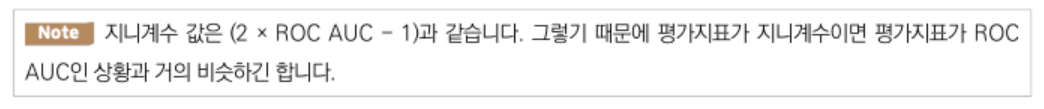

정규화 지니계수는 값이 0에 가까울 수록 성능이 나쁘고, 1에 가까울수록 성능이 좋다는 의미이다.

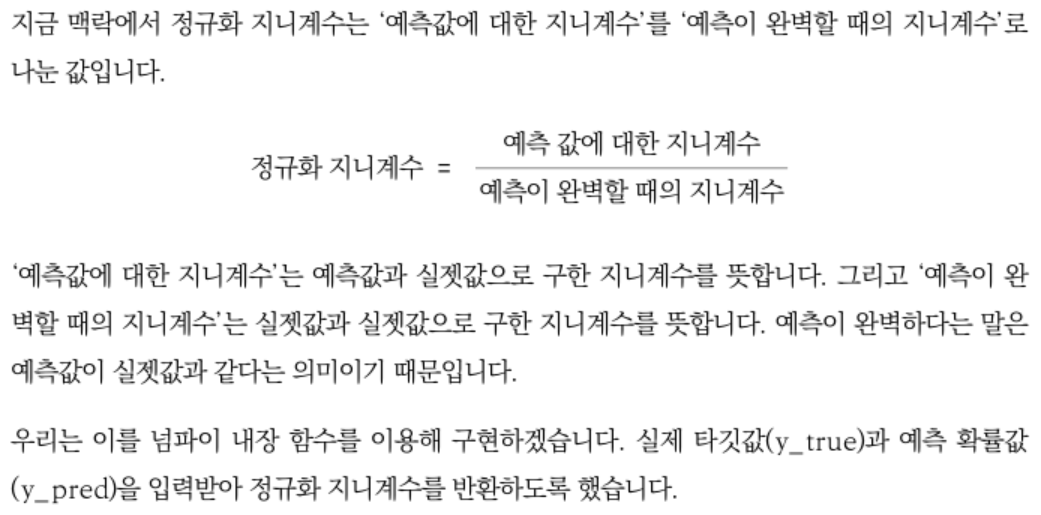

In [35]:
def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape # 참일때 동작
    
    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값
    
    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [36]:
# LGBM용 gini 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

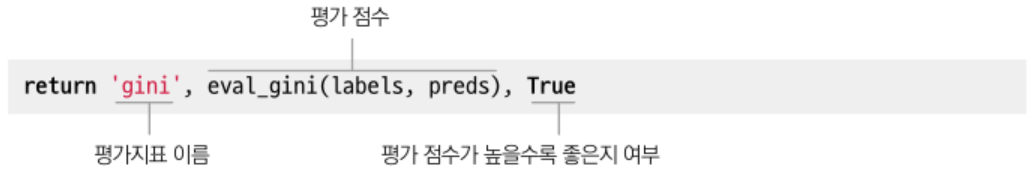

#### 모델 훈련 및 성능 검증

OOF 방식으로 LightGBM 훈련

In [37]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [38]:
params = {'objective': 'binary',
          'learning_rate': 0.01,
          'force_row_wise': True,
          'random_state': 0}

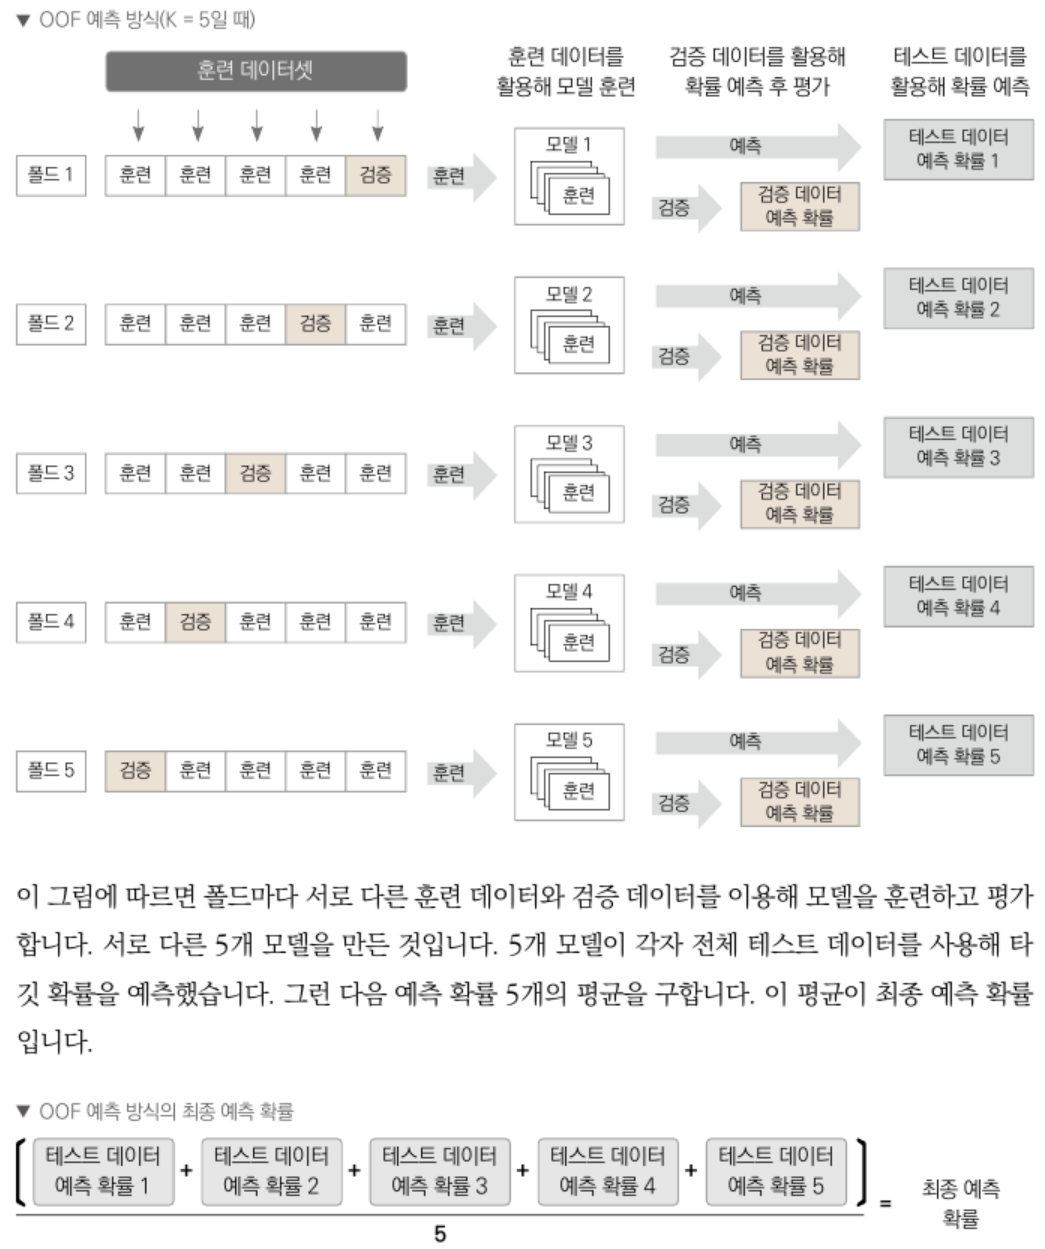

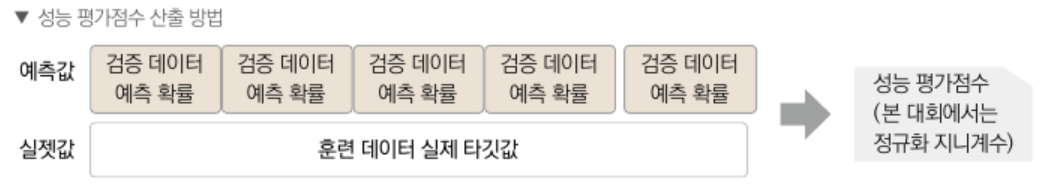

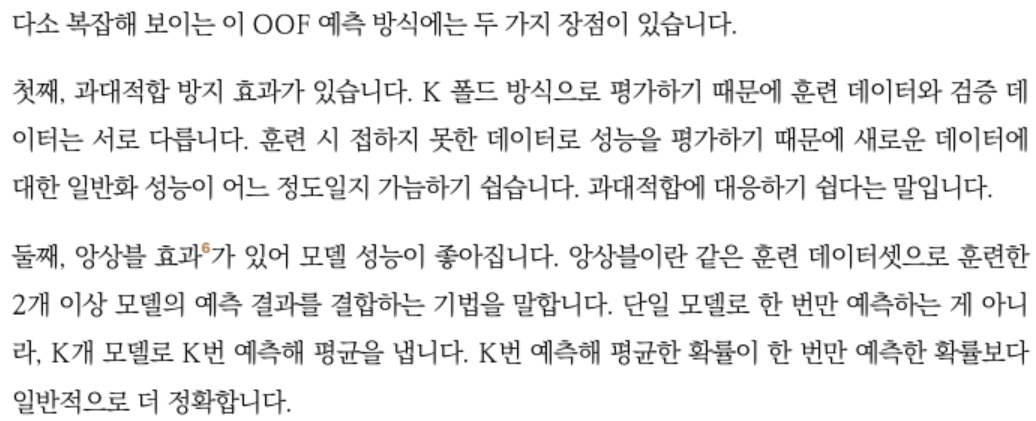

여기서는 StratifiedKFold를 사용한다.  
타깃이 불균형하기 때문이다.

In [39]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

In [40]:
import lightgbm as lgb

In [41]:
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)
    
    # LightGBM 모델 훈련 
    lgb_model = lgb.train(params=params,        # 훈련용 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=1000, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini,           # 검증용 평가지표
                          early_stopping_rounds=100, # 조기종료 조건
                          verbose_eval=100)     # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.153354	valid_0's gini: 0.261651
[200]	valid_0's binary_logloss: 0.152426	valid_0's gini: 0.275704
[300]	valid_0's binary_logloss: 0.152023	valid_0's gini: 0.282277
[400]	valid_0's binary_logloss: 0.1518	valid_0's gini: 0.286648
[500]	valid_0's binary_logloss: 0.151713	valid_0's gini: 0.287944
[600]	valid_0's binary_logloss: 0.151672	valid_0's gini: 0.288637
[700]	valid_0's binary_logloss: 0.151659	valid_0's gini: 0.288939
Early stopping, best iteration is:
[681]	valid_0'

In [42]:
print('OOF 검증 데이터 지니계수:', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수: 0.2804995714877777


In [43]:
submission['target'] = oof_test_preds
submission.to_csv('data/porto-seguro-safe-driver-prediction/submission.csv')

### 성능개선